In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.optimize import least_squares

data = pd.read_excel('data-3.xlsx')

print(data)

    Unnamed: 0   t        y(t)
0          NaN   1    2.654646
1          NaN   2    5.103462
2          NaN   3    5.060375
3          NaN   4    6.902147
4          NaN   5    5.453315
5          NaN   6    8.899777
6          NaN   7    8.205648
7          NaN   8   11.062798
8          NaN   9   13.539370
9          NaN  10   13.924438
10         NaN  11   17.709211
11         NaN  12   20.438343
12         NaN  13   22.508486
13         NaN  14   26.560064
14         NaN  15   30.194273
15         NaN  16   35.158863
16         NaN  17   39.871998
17         NaN  18   42.878044
18         NaN  19   48.936783
19         NaN  20   56.374283
20         NaN  21   63.208462
21         NaN  22   70.443115
22         NaN  23   80.115349
23         NaN  24   90.663902
24         NaN  25  105.818893


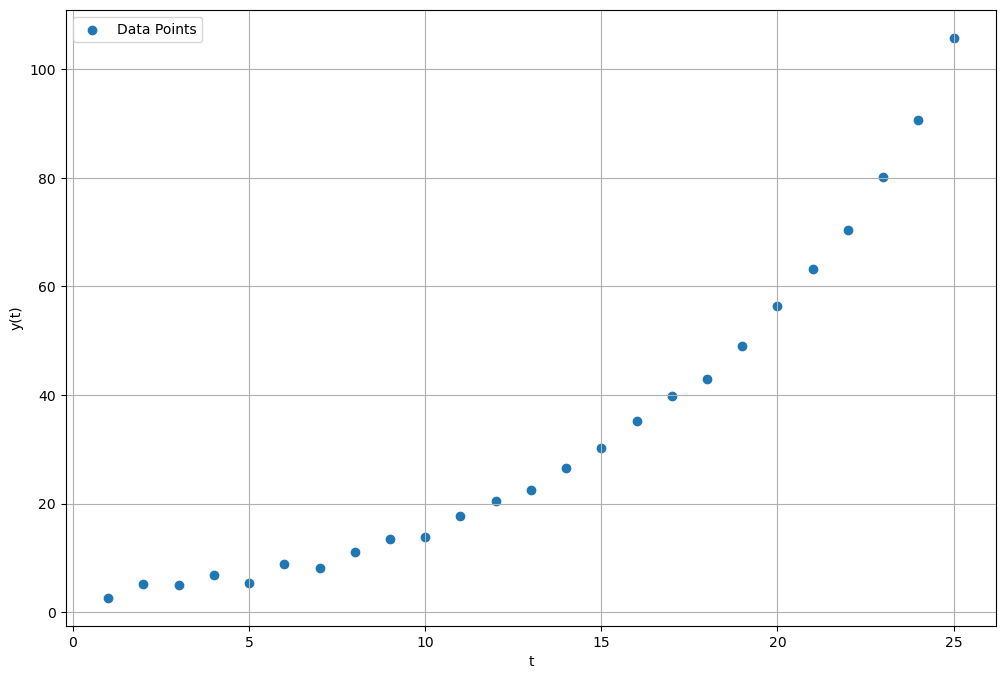

In [124]:
# Extract the "t" and "y(t)" columns
t = data['t']
y = data['y(t)']

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(t, y, label="Data Points")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend()
plt.grid(True)
plt.show()

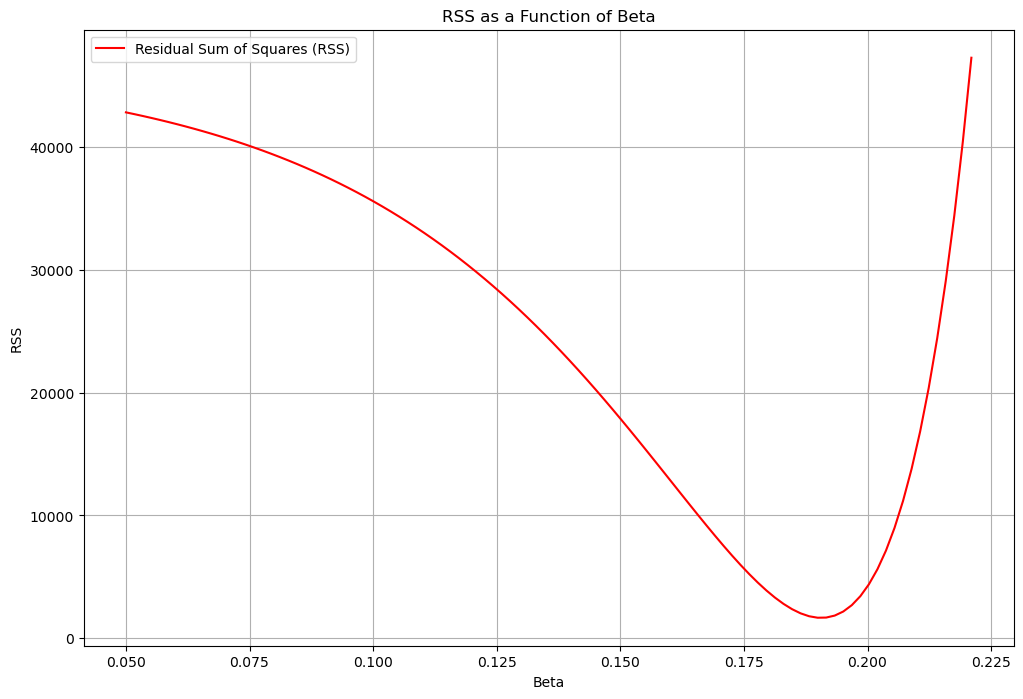

In [125]:
# Model function
def model_function(t, alpha1, alpha2, beta):
    return alpha1 + alpha2 * np.exp(beta * t)

# Define a function to compute RSS
def calculate_residual_sum_of_squares(alpha1, alpha2, beta):
    predictions = model_function(t, alpha1, alpha2, beta)
    residuals = y - predictions
    return np.sum(residuals**2)

# Vary beta values
beta_values = np.linspace(0.221, 0.05, 100)

# Calculate RSS for each beta value
rss_values = [calculate_residual_sum_of_squares(1.0, 1.0, beta) for beta in beta_values]
# Plot the RSS as a function of beta
plt.figure(figsize=(12, 8))
plt.plot(beta_values, rss_values, label='Residual Sum of Squares (RSS)', color='red')
plt.xlabel('Beta')
plt.ylabel('RSS')
plt.title('RSS as a Function of Beta')
plt.legend()
plt.grid(True)
plt.show()

In [126]:
# Define the residual function
def residual(x):
    return y - x[0] - x[1] * np.exp(x[2] * t)

# Define the Jacobian matrix
def jacobian(x):
    return np.array([
        -np.ones_like(t),
        -np.exp(x[2] * t),
        -x[1] * t * np.exp(x[2] * t)
    ]).T


x = np.array([1, 0, 0.1])  

for i in range(15):
    x = x + la.lstsq(jacobian(x), -residual(x))[0]

alpha1, alpha2, beta = x[0], x[1], x[2]
print("Estimated Parameters:")
print(f"α1: {alpha1}")
print(f"α2: {alpha2}")
print(f"β: {beta}")

Estimated Parameters:
α1: -2.889572579826152
α2: 5.495345022925228
β: 0.11860379426006337


In [131]:
# Given parameter values
new_alpha1 = -2.889572579826152
new_alpha2 = 5.495345022925228
new_beta = 0.11860379426006337

new_predicted_values = model_function(t, new_alpha1, new_alpha2, new_beta)
new_residuals = y - new_predicted_values
new_variance_estimate = np.var(new_residuals)

# Print the estimate of σ²
print(f"Estimated σ²: {new_variance_estimate:.6f}")

Estimated σ²: 0.961930


In [134]:
import numpy as np
from scipy.stats import t as t_distribution

new_alpha1_est = -2.889572579826159 
new_alpha2_est = 5.495345022925234 
new_beta_est = 0.11860379426006332  

new_y_observed = np.array([2.65464592, 5.10346174, 5.06037521, 6.90214729, 5.45331526, 8.89977741, 8.20564842, 11.06279755, 13.53936958, 13.92443752, 17.70921135, 20.43834305, 22.50848579, 26.56006432, 30.19427299, 35.15886307, 39.87199783, 42.87804413, 48.93678284, 56.37428284, 63.20846176, 70.44311523, 80.11534882, 90.66390228, 105.81889343])

def model_function(t, alpha1, alpha2, beta):
    return alpha1 + alpha2 * np.exp(beta * t)

new_residuals = new_y_observed - model_function(np.arange(1, 26), new_alpha1_est, new_alpha2_est, new_beta_est)

def fisher_information_matrix(alpha1, alpha2, beta, t, residuals):
    n = len(t)
    var_residuals = np.var(residuals)
    d_alpha1 = np.ones(n) / var_residuals
    d_alpha2 = np.exp(2 * beta * t) / var_residuals
    d_beta = 2 * alpha2 * t * np.exp(2 * beta * t) / var_residuals
    fisher_matrix = np.array([
        [np.sum(d_alpha1), np.sum(d_alpha2), np.sum(d_beta)],
        [np.sum(d_alpha2), np.sum(d_alpha2 ** 2), np.sum(d_alpha2 * d_beta)],
        [np.sum(d_beta), np.sum(d_alpha2 * d_beta), np.sum(d_beta ** 2)]
    ])
    return fisher_matrix

new_fisher_matrix = fisher_information_matrix(new_alpha1_est, new_alpha2_est, new_beta_est, np.arange(1, 26), new_residuals)

# Calculate the standard errors
new_covariance_matrix = np.linalg.inv(new_fisher_matrix)
new_standard_errors = np.sqrt(np.diag(new_covariance_matrix))

# Define the confidence level (e.g., 95% confidence interval)
new_confidence_level = 0.95

# Calculate the critical t-value for the confidence interval
new_alpha = 1 - new_confidence_level
new_t_critical = t_distribution.ppf(1 - new_alpha / 2, len(new_y_observed) - 3)  # df = n - number of parameters

# Construct confidence intervals for each parameter
new_conf_int_alpha1 = (new_alpha1_est - new_t_critical * new_standard_errors[0], new_alpha1_est + new_t_critical * new_standard_errors[0])
new_conf_int_alpha2 = (new_alpha2_est - new_t_critical * new_standard_errors[1], new_alpha2_est + new_t_critical * new_standard_errors[1])
new_conf_int_beta = (new_beta_est - new_t_critical * new_standard_errors[2], new_beta_est + new_t_critical * new_standard_errors[2])

# Print confidence intervals
print("Confidence Intervals ({}%):".format(new_confidence_level * 100))
print("α1: ({:.4f}, {:.4f})".format(new_conf_int_alpha1[0], new_conf_int_alpha1[1]))
print("α2: ({:.4f}, {:.4f})".format(new_conf_int_alpha2[0], new_conf_int_alpha2[1]))
print("β: ({:.4f}, {:.4f})".format(new_conf_int_beta[0], new_conf_int_beta[1]))





Confidence Intervals (95.0%):
α1: (-3.5569, -2.2222)
α2: (5.4440, 5.5467)
β: (0.1184, 0.1188)


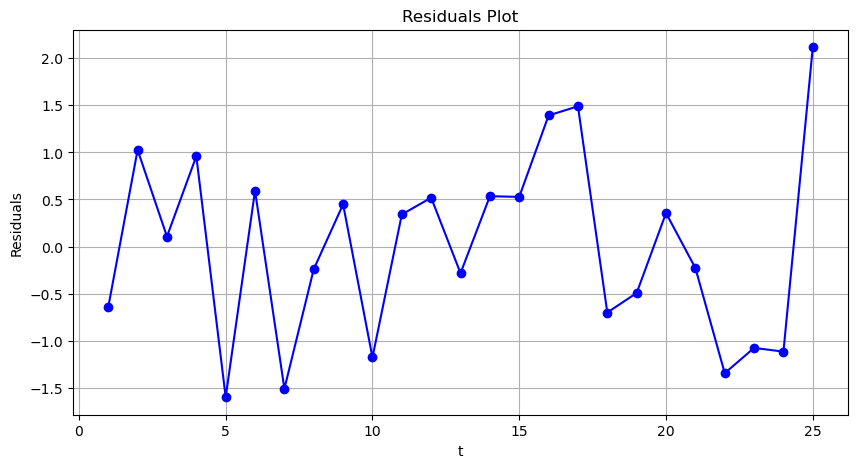

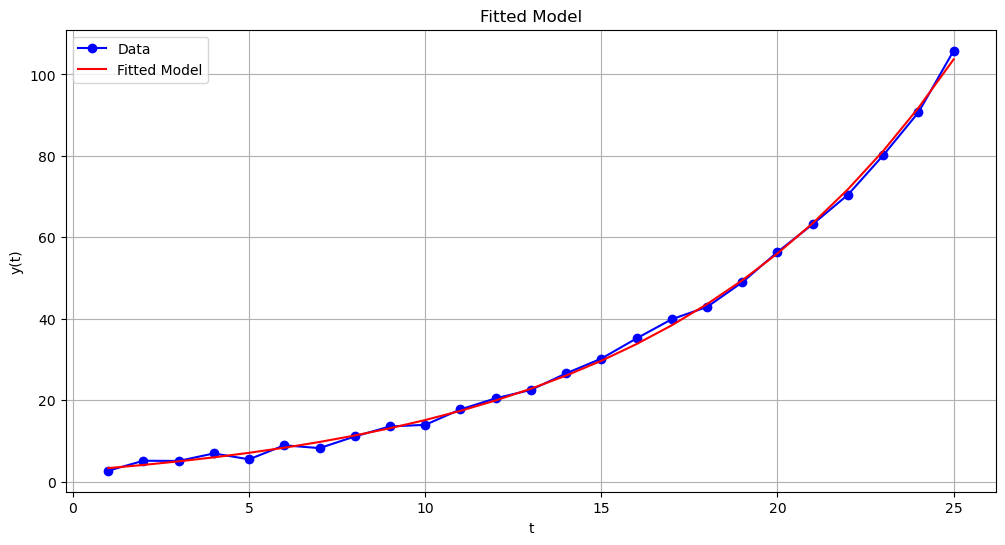

In [135]:
t = data['t']
y = data['y(t)']

def model(t, α1, α2, β):
    return α1 + α2 * np.exp(β * t)

α1_hat = -2.889572579826159 
α2_hat = 5.495345022925234 
β_hat = 0.11860379426006332

y_pred = model(t, α1_hat, α2_hat, β_hat)

residuals = y - y_pred

plt.figure(figsize=(10, 5))
plt.plot(t, residuals, marker='o', linestyle='-', color='b')
plt.xlabel('t')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

y_pred = model(t, α1_hat, α2_hat, β_hat)

plt.figure(figsize=(12, 6))
plt.plot(t, y, marker='o', linestyle='-', color='b', label='Data')
plt.plot(t, y_pred, linestyle='-', color='r', label='Fitted Model')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Fitted Model')
plt.legend()
plt.grid(True)
plt.show()

Shapiro-Wilk Test for Normality:
Statistic: 0.9694320559501648
P-value: 0.6306994557380676
The residuals appear to be normally distributed (fail to reject H0).


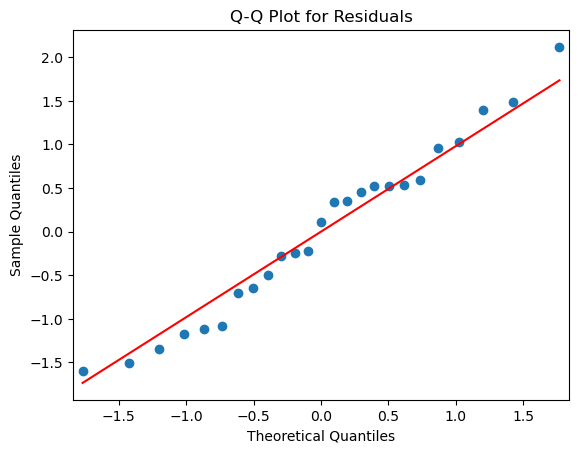

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import statsmodels.api as sm

# Perform the Shapiro-Wilk test for normality
stat, p = shapiro(residuals)
alpha = 0.05  # significance level

print("Shapiro-Wilk Test for Normality:")
print(f"Statistic: {stat}")
print(f"P-value: {p}")

if p > alpha:
    print("The residuals appear to be normally distributed (fail to reject H0).")
else:
    print("The residuals do not appear to be normally distributed (reject H0).")

# Plot a Q-Q plot to visualize normality
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot for Residuals")
plt.show()

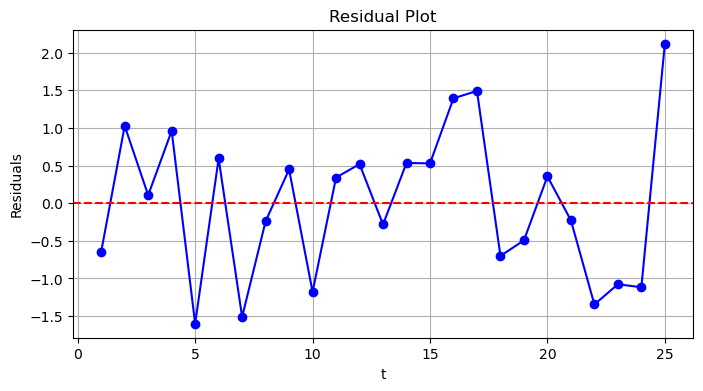

Estimated Parameters:
α1_hat = -2.889538944760177
α2_hat = 5.495342246910873
β_hat = 0.11860378105021548
Estimated Variance (σ^2) = 1.0931022268220796


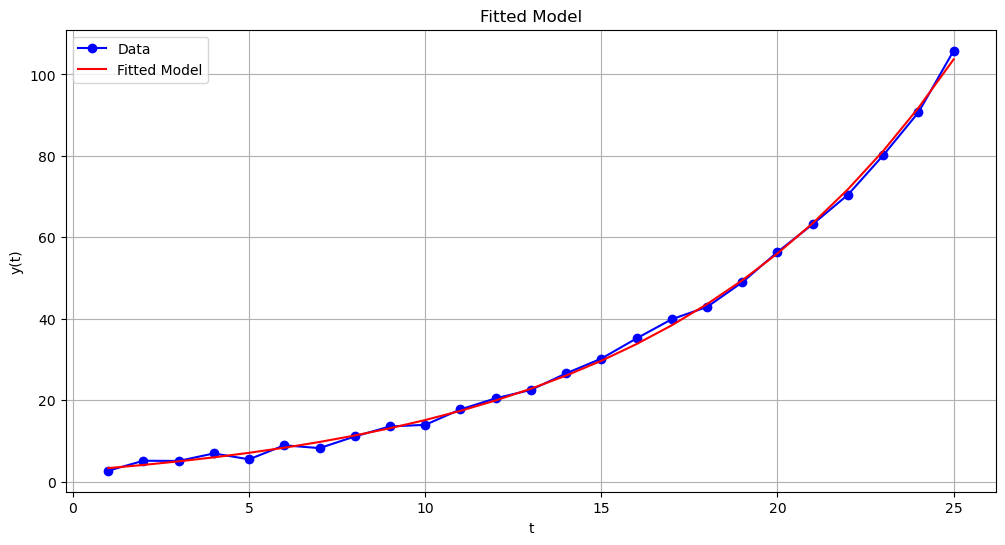

In [137]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


def model(t, α1, α2, β):
    return α1 + α2 * np.exp(β * t)

def residuals(params, t, y):
    α1, α2, β = params
    return y - model(t, α1, α2, β)

# Set initial parameter values and bounds for optimization
initial_guess = [0.2, 0, 0.2]
bounds = [(None, None), (None, None), (None, None)]
# Optimize the parameters to minimize the sum of squared residuals using Nelder-Mead method
result = minimize(lambda params: np.sum(residuals(params, t, y) ** 2), initial_guess, bounds=bounds, method='Nelder-Mead')

# Extract the estimated parameters
α1_hat, α2_hat, β_hat = result.x

# Calculate the residuals using the estimated parameters
residuals = residuals(result.x, t, y)

# Visualize the residuals in a plot
plt.figure(figsize=(8, 4))
plt.plot(t, residuals, marker='o', linestyle='-', color='b')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('t')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

# Compute the estimate of the variance (σ^2)
σ2_hat = np.sum(residuals ** 2) / (len(t) - 3)  # Degrees of freedom: n - number of parameters

# Display the results and model fit
print("Estimated Parameters:")
print(f"α1_hat = {α1_hat}")
print(f"α2_hat = {α2_hat}")
print(f"β_hat = {β_hat}")

print("Estimated Variance (σ^2) =", σ2_hat)

# Calculate the predicted 'y' values using the estimated parameters
y_pred = model(t, α1_hat, α2_hat, β_hat)

# Create a plot to visualize the original data and the fitted model
plt.figure(figsize=(12, 6))
plt.plot(t, y, marker='o', linestyle='-', color='b', label='Data')
plt.plot(t, y_pred, linestyle='-', color='r', label='Fitted Model')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Fitted Model')
plt.legend()
plt.grid(True)
plt.show()

Shapiro-Wilk Test for Normality:
Statistic: 0.9694356918334961
P-value: 0.630790114402771
The residuals appear to be normally distributed (fail to reject H0).


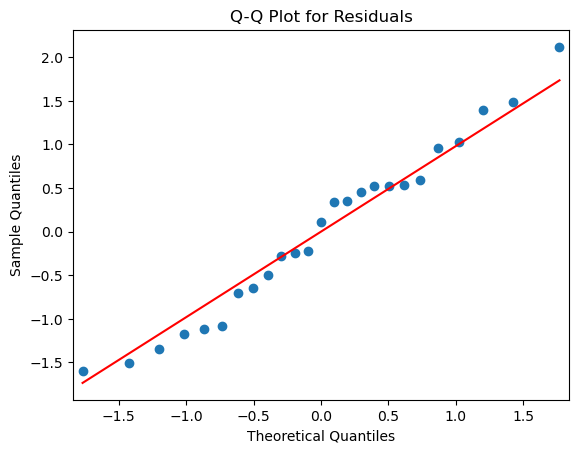

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import statsmodels.api as sm

# Perform the Shapiro-Wilk test for normality
stat, p = shapiro(residuals)
alpha = 0.05  # significance level

print("Shapiro-Wilk Test for Normality:")
print(f"Statistic: {stat}")
print(f"P-value: {p}")

if p > alpha:
    print("The residuals appear to be normally distributed (fail to reject H0).")
else:
    print("The residuals do not appear to be normally distributed (reject H0).")

# Plot a Q-Q plot to visualize normality
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot for Residuals")
plt.show()

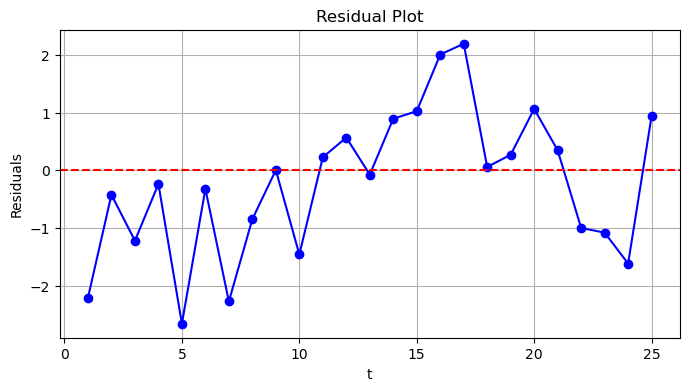

Estimated Parameters:
α1_hat = 3.363976076250313
α2_hat = 0.9140602461033733
β1_hat = 0.1279730962704348
β2_hat = 0.12796824712411153

Residual Sum of Squares (RSS): 39.85794200243713
Estimated Variance (σ^2) = 1.8979972382112917


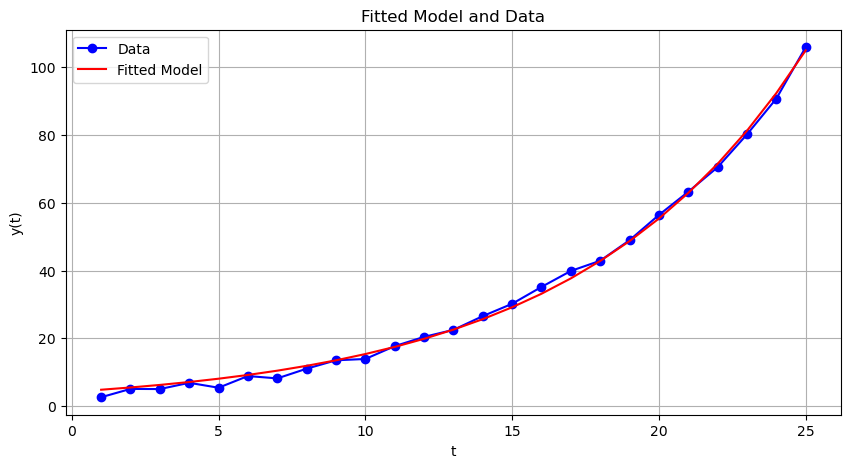

In [139]:

t = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])
y = np.array([
    2.65464592, 5.10346174, 5.06037521, 6.90214729, 5.45331526, 8.89977741, 8.20564842, 11.06279755, 13.53936958,
    13.92443752, 17.70921135, 20.43834305, 22.50848579, 26.56006432, 30.19427299, 35.15886307, 39.87199783,
    42.87804413, 48.93678284, 56.37428284, 63.20846176, 70.44311523, 80.11534882, 90.66390228, 105.81889343
])

# Define the model function
def model(t, α1, α2, β1, β2):
    return α1 * np.exp(β1 * t) + α2 * np.exp(β2 * t)

# Define the residuals function
def residuals(params, t, y):
    α1, α2, β1, β2 = params
    return y - model(t, α1, α2, β1, β2)
# Set initial parameter values and bounds
initial_guess = [1.0, 1.0, 0.1, 0.1]  # You can adjust these initial values
bounds = [(None, None), (None, None), (None, None), (None, None)]

# Minimize the sum of squared residuals using the Nelder-Mead method
result = minimize(lambda params: np.sum(residuals(params, t, y) ** 2), initial_guess, bounds=bounds, method='Nelder-Mead')

# Get the estimated parameters
α1_hat, α2_hat, β1_hat, β2_hat = result.x

# Calculate and plot the residuals
residuals = residuals(result.x, t, y)
plt.figure(figsize=(8, 4))
plt.plot(t, residuals, marker='o', linestyle='-', color='b')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('t')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()
# Find the estimate of σ^2 (variance)
σ2_hat = np.sum(residuals ** 2) / (len(t) - 4)  # df = n - number of parameters

# Print the results
print("Estimated Parameters:")
print(f"α1_hat = {α1_hat}")
print(f"α2_hat = {α2_hat}")
print(f"β1_hat = {β1_hat}")
print(f"β2_hat = {β2_hat}")

print("\nResidual Sum of Squares (RSS):", np.sum(residuals ** 2))
print("Estimated Variance (σ^2) =", σ2_hat)

# Calculate predicted values and plot the data and fitted model
y_pred = model(t, α1_hat, α2_hat, β1_hat, β2_hat)
plt.figure(figsize=(10, 5))
plt.plot(t, y, marker='o', linestyle='-', color='b', label='Data')
plt.plot(t, y_pred, linestyle='-', color='r', label='Fitted Model')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Fitted Model')
plt.legend()
plt.grid(True)
plt.show()